# Data

In [1]:
# packages
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# load data
data = pd.read_csv(
    "https://github.com/ackerman-alex/IDS789_credit_card_fraud_detection/raw/refs/heads/main/data/train_selected_features.csv"
)

In [3]:
# check
data.sample(n=5)

,Amount,datetime,Count_number_transactions_last24,Card_Bank_Issuer,Card_Bank_Type,Count_Number_Devices_associated,Count_names_associated_card,hour,billing_region,Count_Devices_ascoiated_card,dayofweek,Count_number_transactions_lasthour,Count_other_cards_associated,Count_products_associated_card,card_product_type,isFraud
90398,33.814,1887560,1.0,16136,204.0,1.0,1.0,20,299.0,1.0,6,1.0,1.0,1.0,138.0,0
195,59.000,89625,0.0,17400,174.0,0.0,1.0,0,269.0,1.0,0,0.0,0.0,1.0,226.0,0
308262,312.950,7669844,4.0,2884,490.0,2.0,2.0,18,204.0,2.0,3,0.0,0.0,2.0,226.0,0
6359,117.000,221610,1.0,9479,562.0,1.0,2.0,13,325.0,2.0,1,0.0,0.0,1.0,102.0,0
270918,68.500,6566672,1.0,15186,512.0,1.0,1.0,0,299.0,1.0,5,0.0,0.0,1.0,224.0,0


In [4]:
# make label
X = data.drop(columns=["isFraud"])
y = data["isFraud"]

In [5]:
# split set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Support Vector Machine
Had to make it linear because of the size of the dataset

In [6]:
# packages for svm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# init
model = LinearSVC(max_iter=10000, class_weight="balanced")

# train
model.fit(X_train_scaled, y_train)

LinearSVC(class_weight='balanced', max_iter=10000)

In [9]:
# predictions
y_pred = model.predict(X_test_scaled)

# evaluate
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.6627070139194635

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79    113866
           1       0.06      0.54      0.10      4242

    accuracy                           0.66    118108
   macro avg       0.52      0.60      0.45    118108
weighted avg       0.94      0.66      0.77    118108



In [10]:
# set up a range for 'C'
param_grid = {"C": [0.1, 1, 10, 100]}

# set up GridSearchCV
grid_search = GridSearchCV(
    LinearSVC(max_iter=10000, class_weight="balanced"),
    param_grid,
    cv=5,
    scoring="accuracy",
)

# fit grid search
grid_search.fit(X_train_scaled, y_train)

# display
print("Best C value:", grid_search.best_params_["C"])
print("Best cross-validation accuracy:", grid_search.best_score_)

# retrain
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

Best C value: 1
Best cross-validation accuracy: 0.6624678242248947


LinearSVC(C=1, class_weight='balanced', max_iter=10000)

In [11]:
# check again

# predictions
y_pred_best = best_model.predict(X_test_scaled)

# evaluate
print("\nTuned Model Accuracy Score:", accuracy_score(y_test, y_pred_best))
print(
    "\nTuned Model Classification Report:\n", classification_report(y_test, y_pred_best)
)


Tuned Model Accuracy Score: 0.6627070139194635

Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79    113866
           1       0.06      0.54      0.10      4242

    accuracy                           0.66    118108
   macro avg       0.52      0.60      0.45    118108
weighted avg       0.94      0.66      0.77    118108



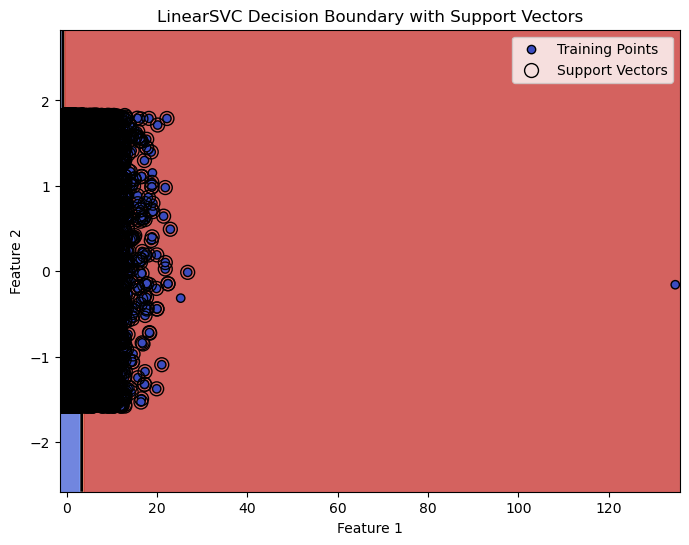

In [ ]:
# weight vector and intercept model
coef = model.coef_.flatten()
intercept = model.intercept_

# grid to evaluate the decision function
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1, 100),
    np.linspace(X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1, 100),
)

# calculate decision function values
Z = coef[0] * xx + coef[1] * yy + intercept
Z = np.sign(Z)

# plot the decision boundary and margins
plt.figure(figsize=(8, 6))

# plot decision boundary where decision function is 0
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

# plot the decision boundary line where Z == 0
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")

# plot the training data points
plt.scatter(
    X_train_scaled[:, 0],
    X_train_scaled[:, 1],
    c=y_train,
    cmap=plt.cm.coolwarm,
    edgecolors="k",
    marker="o",
    label="Training Points",
)

# - identify the support vectors based on their distance from the decision boundary
# - using a rough estimate, support vectors are those points close to the decision boundary.
# - for LinearSVC, we don't have direct access to support vectors like in SVC, so we'll use this trick
margin = 1 / np.linalg.norm(coef)

# find the decision boundary distance for each point in the training set
distances = np.abs(np.dot(X_train_scaled, coef) + intercept) / np.linalg.norm(coef)

# highlight points that are within a small threshold of the margin (these are approximate support vectors)
threshold = margin * 1.1
support_vector_mask = distances < threshold

# plot the approximate support vectors
plt.scatter(
    X_train_scaled[support_vector_mask, 0],
    X_train_scaled[support_vector_mask, 1],
    facecolors="none",
    edgecolors="k",
    s=100,
    label="Support Vectors",
    marker="o",
)

# labels and title
plt.title("LinearSVC Decision Boundary with Support Vectors")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="best")

# display
plt.show()

# Guassian Naive Bayes

In [13]:
# packages
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [14]:
# in the event of imbalanced data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [15]:
# init
model2 = GaussianNB()

# fit
model2.fit(X_resampled, y_resampled)

GaussianNB()

In [16]:
# predictions
y_pred = model2.predict(X_test)

# evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.95788600264165
Confusion Matrix:
[[113034    832]
 [  4142    100]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    113866
           1       0.11      0.02      0.04      4242

    accuracy                           0.96    118108
   macro avg       0.54      0.51      0.51    118108
weighted avg       0.93      0.96      0.94    118108



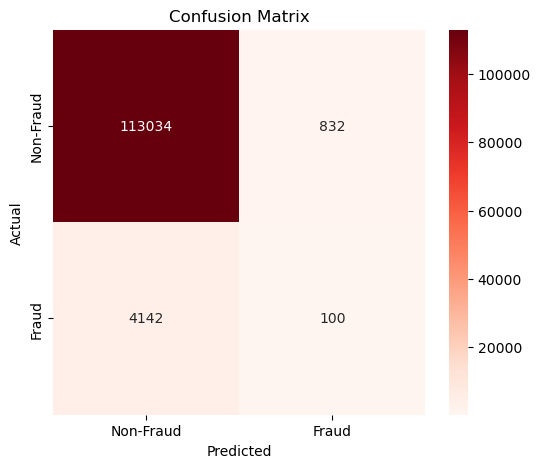

In [17]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Non-Fraud", "Fraud"],
    yticklabels=["Non-Fraud", "Fraud"],
)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()